# CIFAR-10 - Object Recognition in Images- for beginners (score: ~90%)

This notebook refers to Kaggle competition "CIFAR-10 - Object Recognition in Images",
which can be found here: https://www.kaggle.com/c/cifar-10 . <br>
It is written for begginers as we were at when we joined the competition. <br>
The notebook was checked on a clean environment and it installs everything needed. <br>
We hope it will help you to get started. Feel free to contact us with any question or comment. <br><br>
Maor Vaknin - vaknin.mj@gmail.com <br>
Itay Cohen

## 1. Data

### This section downloads and builds the data from Kaggle and installs the needed packages.
### You only need to run it once. If It's not your first run, you can jump to section 2.

We found two versions of the data- <br>
> 1. from Kaggle <br>
> 2. from Kers datasets <br>

The colors in the Kaggle dataset are different from those in the Keras dataset. <br>
This means that if you train on the Keras dataset, you can get low score on Kaggle dataset. <br>
However, we found that the Keras dataset is easier to work with, <br>
and you can find some commented lines regarding the keras dataset. <br>
This notebook uses the Kaggle dataset in order to make the submission to Kaggle easier. <br>

### Install Kaggle API and download the data

In [1]:
# Downloading the dataset using Kaggle API. Please read the API guide if this is your first use.
# You can find the guide here: https://www.kaggle.com/docs/api

# Install Kaggle API
!conda install --yes -c conda-forge kaggle
# !python -m pip install kaggle

# Download the dataset from Kaggle
# Note: We had some issues with running Kaggle API commands from the notebook.
# If you experience such issues, just run the command (without the "!" on conda prompt)
!kaggle competitions download -c cifar-10 

### Prepare the data

In [2]:
!conda install --yes -c conda-forge patool
# The data is zipped, let's unzip it
import patoolib
patoolib.extract_archive("cifar-10.zip", outdir="data")
!conda install --yes -c solutionsdev py7zr

In [3]:
import py7zr
with py7zr.SevenZipFile('data/train.7z', mode='r') as z:
    z.extractall('data')

In [4]:
# Be patient, running this block will take a while.
with py7zr.SevenZipFile('data/test.7z', mode='r') as z:
    z.extractall('data')

In [5]:
import os
# Let's delete the "zip" and "7z" files as we already extracted them
os.remove("data/train.7z")
os.remove("data/test.7z")
os.remove("cifar-10.zip")

### prerequisites

In [6]:
!conda install --yes -c conda-forge glob2
!conda install --yes -c conda-forge opencv

!conda install --yes -c anaconda numpy
!conda install --yes -c anaconda pandas
!conda install --yes -c anaconda tensorflow-gpu
!conda install --yes -c conda-forge scikit-learn 
!conda install --yes -c anaconda pydot
!conda install --yes -c conda-forge matplotlib

The data contains two folders and two files: <br>
> train - a folder with 50,000 train images, which are labeled in trainLabels.csv <br>
> test - a folder with 300,000 test Images with no labels <br>
> trainLabels.csv - contains the labels of the train images <br>
> sampleSubmission.csv - an example of the submission file expected by Kaggle

In [7]:
# For Kaggle dataset. Be patient, running this block will take a while.
import glob
import cv2
import numpy as np 
import os

# Since the folders only contain Images, the size of the datasets is the number of files in it's folder
num_of_train_images = len(glob.glob('data/train/*'))
num_of_test_images = len(glob.glob('data/test/*'))

# Let's create a dataset from the images

train_dir = "data/train" # Enter Directory of train images  
train_images_path = os.path.join(train_dir,'*g')
files = glob.glob(train_images_path)
train_images = [[]]*num_of_train_images
for f1 in files:
    # Extract the image index from the filename
    image_index = int(f1.split("\\")[1].split(".")[0])-1
    img = cv2.imread(f1)
    # Add the image to the dataset
    train_images[image_index] = img


test_dir = "data/test" # Enter Directory of test images 
test_images_path = os.path.join(test_dir,'*g')
files = glob.glob(test_images_path)
test_images = [[]]*num_of_test_images
for f1 in files:
    image_index = int(f1.split("\\")[1].split(".")[0])-1
    img = cv2.imread(f1)
    test_images[image_index] = img

# The RGB values are between 0 and 255, let's divide them so the values will be between 0 and 1
train_images = np.asarray(train_images, dtype=float)/255
test_images = np.asarray(test_images, dtype=float)/255



# If you want, you can save the dataset and load it, instead of running this block each time
np.save("train_images.npy", train_images)
np.save("test_images.npy", test_images)

## 2. data exploration

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
# for Keras dataset only
# Loading the dataset from Keras. Note: here we are also given the test labels.

# import tensorflow as tf
# from tensorflow import keras
# data = keras.datasets.cifar10
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# train_labels = pd.read_csv('data/trainLabels.csv')
# keras.utils.to_categorical(train_labels).astype('uint8')

In [10]:
train_images = np.load("train_images.npy")
test_images = np.load("test_images.npy")

In [11]:
test_images.shape

(300000, 32, 32, 3)

In [12]:
test_images.shape

(300000, 32, 32, 3)

In [13]:
train_labels = pd.read_csv('data/trainLabels.csv')

print("Number of train images: ", train_images.shape[0])
print("Number of test images: ", test_images.shape[0])

Number of train images:  50000
Number of test images:  300000


The images come in RBG format, 32X32 pixels. Therefore (32,32,3). <br>
There are 50,000 train images and 300,000 test images (in the Kaggle dataset) <br>
Let's plot some train images with their true labels:

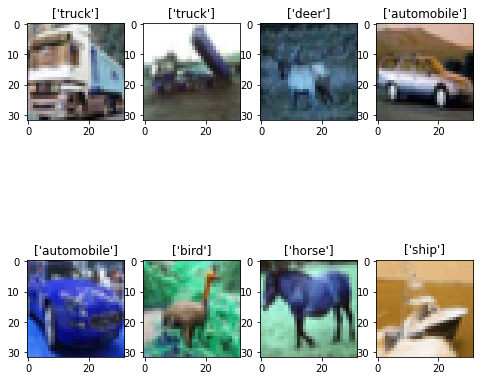

In [14]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    img = train_images[i]
    fig.add_subplot(rows, columns, i, title=[train_labels.label[i]])
    plt.imshow(img)
plt.show()

## 3. Build the Model

In [15]:
import numpy as np 
import pandas as pd 
from tensorflow import keras

# Model architecture
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, datasets,models,layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import load_model

# Data processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12272623325233997571
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3142752665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7080678651059157479
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [17]:
train_labels.head(5)

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [18]:
classes = list(set(list(train_labels.label)))
classes

['dog',
 'bird',
 'frog',
 'ship',
 'horse',
 'airplane',
 'automobile',
 'truck',
 'cat',
 'deer']

In [19]:
num_classes=len(classes)

In [20]:
labels_dict =  {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
labels_dict_reversed = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

In [21]:
train_labels['Category'] = train_labels.label.map(labels_dict_reversed)

In [22]:
# The categories are represented by numbers from 0 to 9.
# Our network needs another representation- a vector of 0's and 1's.
# This function converts the categories to a One-hot vector.
# For example, if the label is 3, then the function will return [0,0,0,1,0,0,0,0,0,0]
train_labels_categories = keras.utils.to_categorical(train_labels.Category, num_classes)#.astype('uint8')

# Splitting the training data into train set and validation set
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels_categories, random_state=0, test_size=0.05)

# for Keras dataset only
# x_test = test_images.astype('float32')/255
# y_test = keras.utils.to_categorical(test_labels, num_classes).astype('uint8')

In [23]:
train_labels_categories

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
x_train.shape

(47500, 32, 32, 3)

In [25]:
x_val.shape

(2500, 32, 32, 3)

In order to avoid Overfitting, it is recommended to use augmentation. <br>
For example, we can rotate the image, change the zoom and the centeralization.

In [26]:
# Data augumetation
datagen = ImageDataGenerator(
        rotation_range=0.3,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=True)


In [27]:
model_layers = [
    Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu, depth_multiplier=3),
#     MaxPooling2D(2, 2),
    Dropout(rate =0.1),
    
    
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu),
#     MaxPooling2D(2, 2),
    Dropout(rate = 0.1),
    
    Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu),
#     MaxPooling2D(2, 2),
    Dropout(rate = 0.4),
    
    Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(1,1), strides=(1, 1), padding='same', activation=keras.activations.relu),
    
    
    Conv2D(256, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(3,3), strides=(1, 1), padding='same', activation=keras.activations.relu),
    
    
    
    Conv2D(512, (1, 1), activation='relu', strides=(2, 2), padding='same'),
    BatchNormalization(),
    DepthwiseConv2D(kernel_size=(1,1), strides=(1, 1), padding='same', activation=keras.activations.relu),
    
    Dropout(rate = 0.4),
    
    Flatten(),
    Dropout(rate = 0.3),
    Dense(2048, activation='relu'),
    Dropout(rate = 0.3),
    Dense(512, activation='relu'),
    Dropout(rate = 0.4),
    Dense(10, activation='softmax')
] 
model = Sequential(model_layers)


In [28]:
# A summary of the model. 
# We can see how many parameters are in each layer and the total number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 32, 32, 96)        960       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 16, 16, 64)        6

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

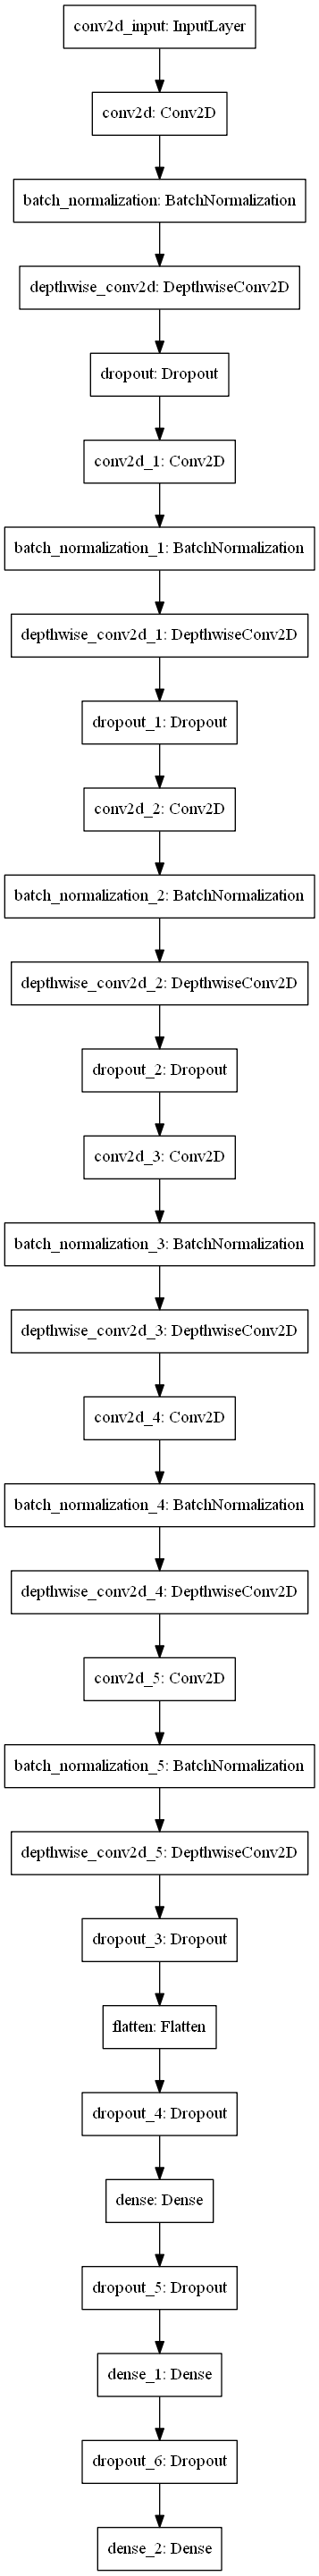

In [30]:
# Visualization of the model
keras.utils.plot_model(model)

In [31]:
# The last epoch does not necessarily produces the best model.
# We want to choose our model wisely,
# so we will save the model that achieved the highest accuracy on the validation set
mcp_save = ModelCheckpoint('best_model', save_best_only=True, monitor='val_accuracy', mode='max')

## 4. Train the model

In [32]:
# Training the model on the augmented train set
model.fit(datagen.flow(x_train, y_train, batch_size=512), validation_data=(x_val, y_val), callbacks=[mcp_save], epochs=100)

  ...
    to  
  ['...']
Train for 93 steps, validate on 2500 samples
Epoch 1/100
92/93 [============================>.] - ETA: 0s - loss: 1.6733 - accuracy: 0.3701WARNING:tensorflow:From C:\Users\vakni\Anaconda3\envs\cifar-10\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model\assets
93/93 [==============================] - 77s 824ms/step - loss: 1.6701 - accuracy: 0.3716 - val_loss: 2.3159 - val_accuracy: 0.0944
Epoch 2/100
93/93 [==============================] - 54s 582ms/step - loss: 1.2575 - accuracy: 0.5420 - val_loss: 2.3193 - val_accuracy: 0.0944
Epoch 3/100
93/93 [==============================] - 66s 709ms/step - loss: 1.0496 - accuracy: 0.6271 - val_loss: 2.3735 - val_

93/93 [==============================] - 62s 668ms/step - loss: 0.1893 - accuracy: 0.9332 - val_loss: 0.3330 - val_accuracy: 0.8960
Epoch 90/100
93/93 [==============================] - 62s 668ms/step - loss: 0.1879 - accuracy: 0.9346 - val_loss: 0.3887 - val_accuracy: 0.8776
Epoch 91/100
93/93 [==============================] - 62s 667ms/step - loss: 0.1810 - accuracy: 0.9361 - val_loss: 0.4838 - val_accuracy: 0.8556
Epoch 92/100
93/93 [==============================] - 63s 672ms/step - loss: 0.1838 - accuracy: 0.9361 - val_loss: 0.4057 - val_accuracy: 0.8740
Epoch 93/100
93/93 [==============================] - 67s 724ms/step - loss: 0.1856 - accuracy: 0.9346 - val_loss: 0.3972 - val_accuracy: 0.8772
Epoch 94/100
93/93 [==============================] - 62s 671ms/step - loss: 0.1811 - accuracy: 0.9364 - val_loss: 0.4285 - val_accuracy: 0.8692
Epoch 95/100
93/93 [==============================] - 63s 677ms/step - loss: 0.1819 - accuracy: 0.9373 - val_loss: 0.3963 - val_accuracy: 0.879

We can see that the train accuracy keeps improving but the validation accuracy is not, Which means wa are Overfitting the model to the data.

In [33]:
# for Keras dataset only
# model.evaluate(x_test, y_test)

## 5. Predict and create Submission file for Kaggle

In [35]:
# Take the best model under the criterion chosen.
# Here we took the model that achieved the highest accuracy on the validation set.
model_ = load_model('best_model', compile=False)

In [36]:
# Now let's use our model to predict the classes of each image in the test set
test_predictions = model.predict_classes(test_images)
test_predictions

array([4, 0, 1, ..., 6, 6, 1], dtype=int64)

In [37]:
test_predictions_df = pd.DataFrame(test_predictions)

In [38]:
# It's easy to use the sample submission file to create our own submission file
samples = pd.read_csv("data/sampleSubmission.csv", index_col=False)

# Replace the sample labels with those our model predicted
samples.label= test_predictions

# Our model predicts the number of the classes of each image.
# Kaggle is expecting a string, for example, if our model predicted "2" we need to translate it to "bird"
samples.replace({"label":labels_dict}, inplace=True)

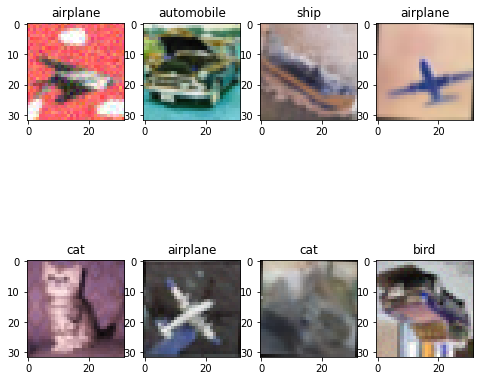

In [39]:
# Let's see how our model predicted some images
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    img = test_images[i]
    fig.add_subplot(rows, columns, i, title=samples.label[i])
    plt.imshow(img)
plt.show()

In [40]:
samples.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c cifar-10 -f submission.csv -m "Submitted using the notebook"

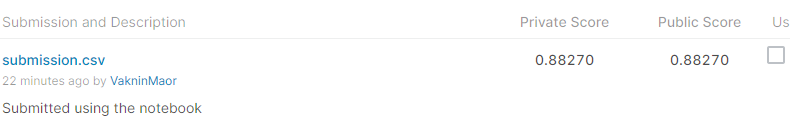

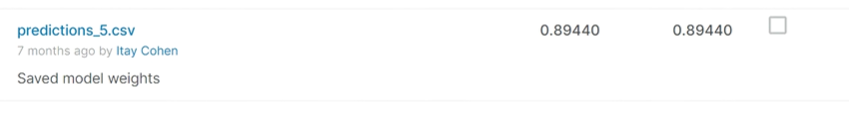